In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

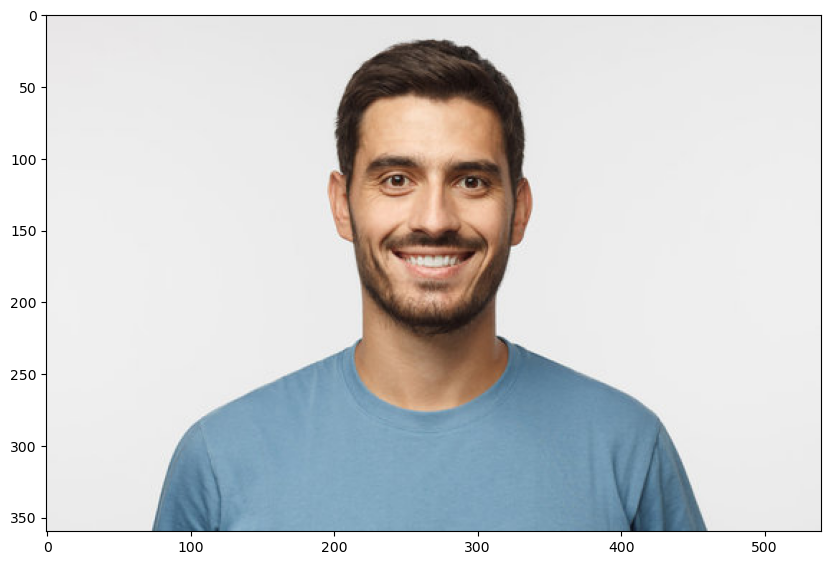

In [2]:
# Read the input image
img1 = cv2.imread('visuals/c0-m14-NB-img1.jpg', cv2.IMREAD_COLOR)
plt.figure(figsize=(10,10))
plt.imshow(img1[:,:,::-1]);

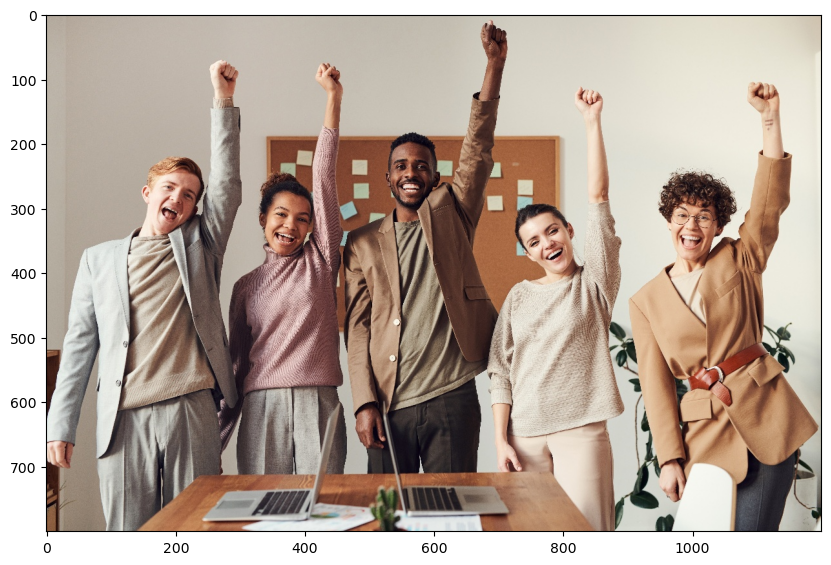

In [9]:
img2 = cv2.imread('visuals/c0-m14-NB-img2.jpg', cv2.IMREAD_COLOR)
plt.figure(figsize=(10,10))
plt.imshow(img2[:,:,::-1]);

In [3]:
def detect(frame, net, scale, mean, in_width, in_height):
    h = frame.shape[0]
    w = frame.shape[1]
    blob = cv2.dnn.blobFromImage(frame, scalefactor = scale, size = (in_width, in_height), 
                                 mean = mean, swapRB = False, crop = False)
    
    net.setInput(blob)
    detections = net.forward()
    
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype('int')
            
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label = 'Confidence: %.4f' % confidence
            label_size, base_line = cv2.getTextSize(label, font_style, font_scale, font_thickness)
            cv2.rectangle(frame, (x1, y1 - label_size[1]), (x1 + label_size[0], y1 + base_line), 
                          (255, 255, 255), cv2.FILLED)
            cv2.putText(frame, label, (x1, y1), font_style, font_scale, (0, 0, 0))
    return frame   

In [4]:
net = cv2.dnn.readNetFromCaffe('./model/deploy.prototxt',
                               './model/res10_300x300_ssd_iter_140000.caffemodel')

In [5]:
mean = [104, 117, 123]
scale = 1.0
in_width = 300
in_height = 300

In [6]:
detection_threshold = 0.5
font_style = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
font_thickness = 1

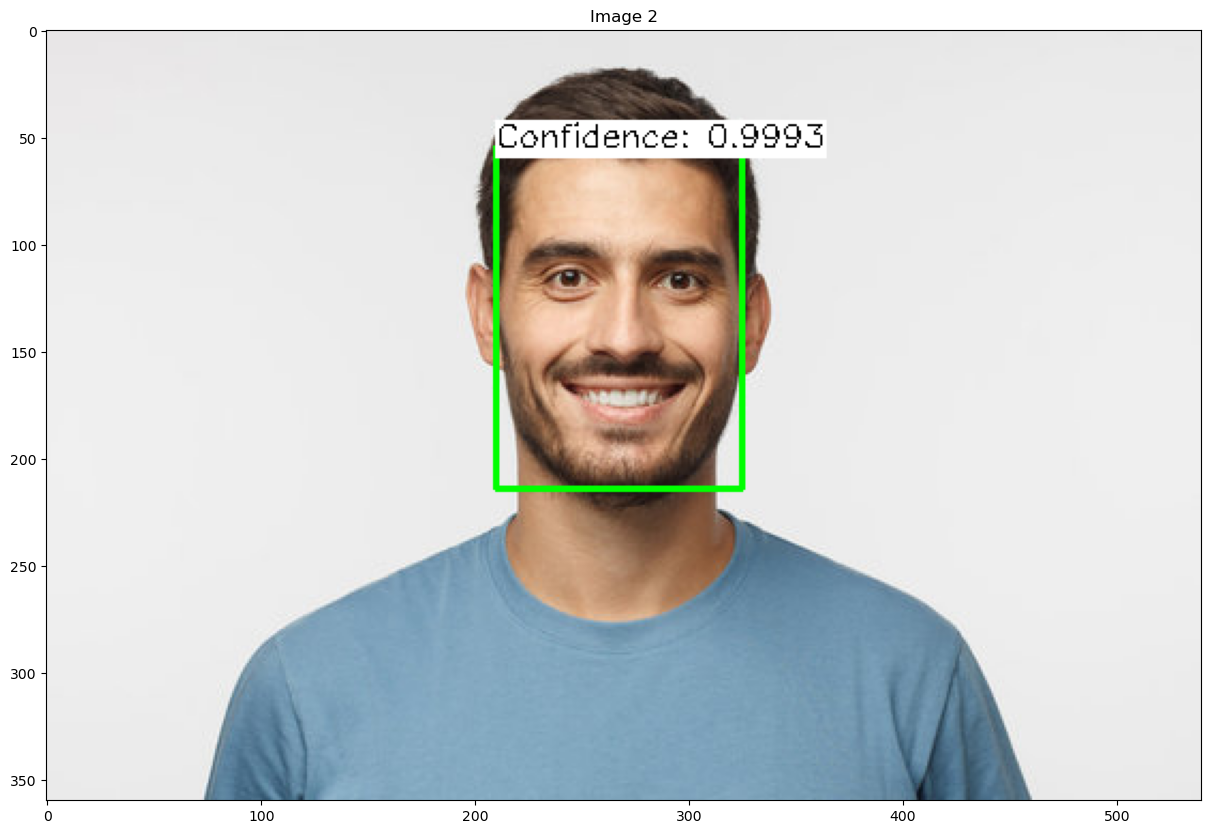

In [7]:
op1 = detect(img1, net, scale, mean, in_width, in_height)

plt.figure(figsize = [15,10])
plt.imshow(op1[:,:,::-1])
plt.title("Image 2");

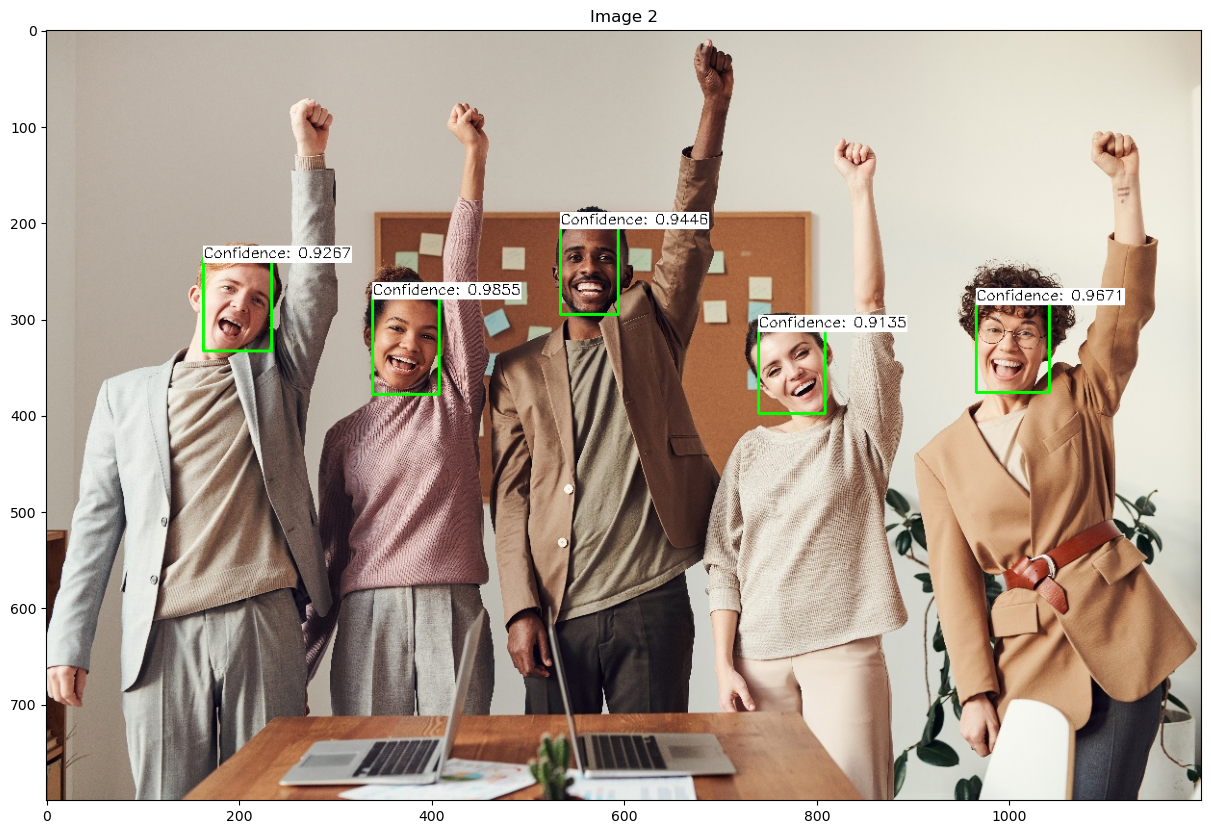

In [10]:
op2 = detect(img2, net, scale, mean, in_width, in_height)

plt.figure(figsize = [15,10])
plt.imshow(op2[:,:,::-1])
plt.title("Image 2");

# facial blur for privacy preservation

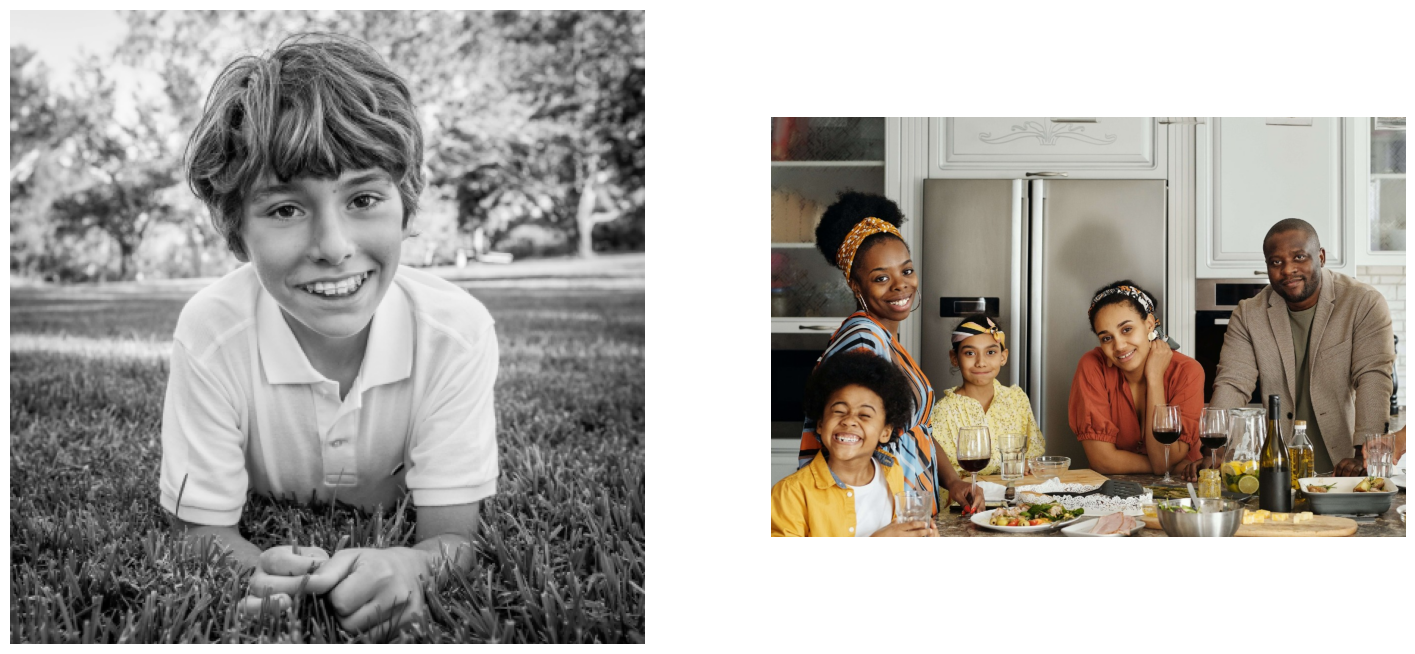

In [15]:
img1 = cv2.imread('./Applications/boy.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('family.jpg', cv2.IMREAD_COLOR)

fig = plt.figure(figsize=(18,10))

plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1])
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2[:,:,::-1]);

In [16]:
def blur(face, factor=3):
    
    h, w  = face.shape[:2]

    if factor < 1: factor = 1 # Maximum blurring
    if factor > 5: factor = 5 # Minimal blurring
    
    # Kernel size.
    w_k = int(w/factor)
    h_k = int(h/factor)

    # Insure kernel is an odd number.
    if w_k%2 == 0: w_k += 1 
    if h_k%2 == 0: h_k += 1 

    blurred = cv2.GaussianBlur(face, (int(w_k), int(h_k)), 0, 0)
    return blurred

In [17]:
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):
    
    img = image.copy()
        
    # Convert the image into a blob format.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    
    # Pass the blob to the DNN model.
    net.setInput(blob)
    
    # Retrieve detections from the DNN model.
    detections = net.forward()
    
    (h, w) = img.shape[:2]
    
    # Process the detetcions.
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:
            
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            # Extract the face ROI.
            face = img[y1:y2, x1:x2]

            face = blur(face, factor=factor)

            # Replace the detected face with the blurred one.
            img[y1:y2, x1:x2] = face
            
    return img

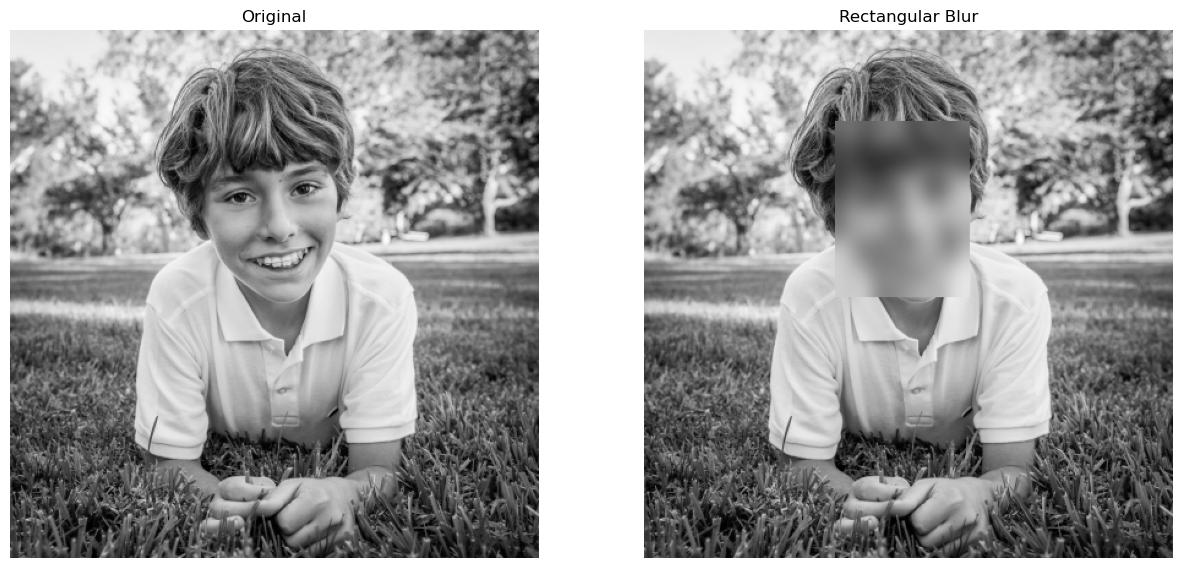

In [18]:
img1_rect = face_blur_rect(img1, net, factor=2.5)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]); plt.title('Rectangular Blur');

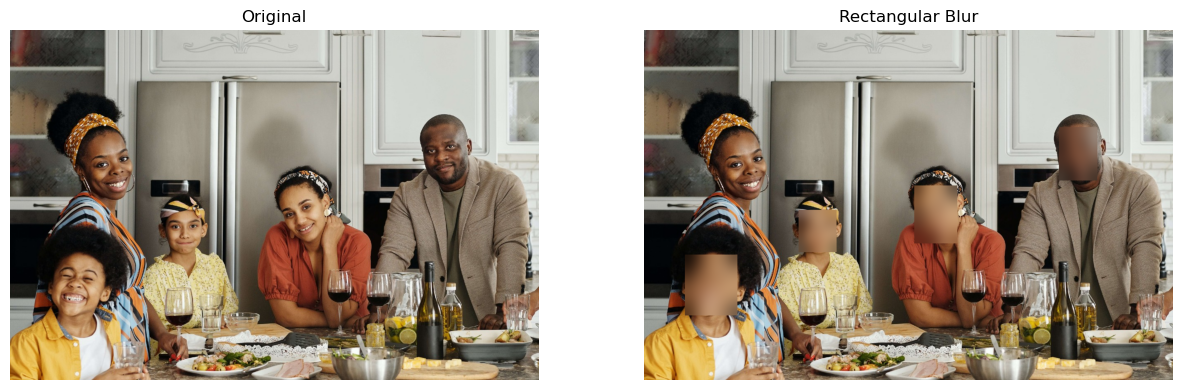

In [22]:
img2_rect = face_blur_rect(img2, net, factor=1)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img2[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img2_rect[:,:,::-1]); plt.title('Rectangular Blur');

In [26]:
def pixelate(roi, pixels=16):
    
    # Size of region to pixelate.
    roi_h, roi_w = roi.shape[:2]
    
    if roi_h > pixels and roi_w > pixels:
        # Resize input ROI to the (small) pixelated size.
        roi_small = cv2.resize(roi, (pixels, pixels), interpolation=cv2.INTER_LINEAR)

        # Now enlarge the pixelated ROI to fill the size of the original ROI.
        roi_pixelated = cv2.resize(roi_small, (roi_w, roi_h), interpolation=cv2.INTER_NEAREST)
    else:
        roi_pixelated = roi

    return roi_pixelated

In [27]:
def face_blur_pixelate(image, net, detection_threshold=0.9, pixels=10):
    img = image.copy()
    
    # Prepare image and perform inference.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    net.setInput(blob)
    detections = net.forward()
    
    h, w = img.shape[:2]
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:
            
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            face = img[y1:y2, x1:x2]
            face = pixelate(face, pixels=pixels)
            img[y1:y2, x1:x2] = face
            
    return img

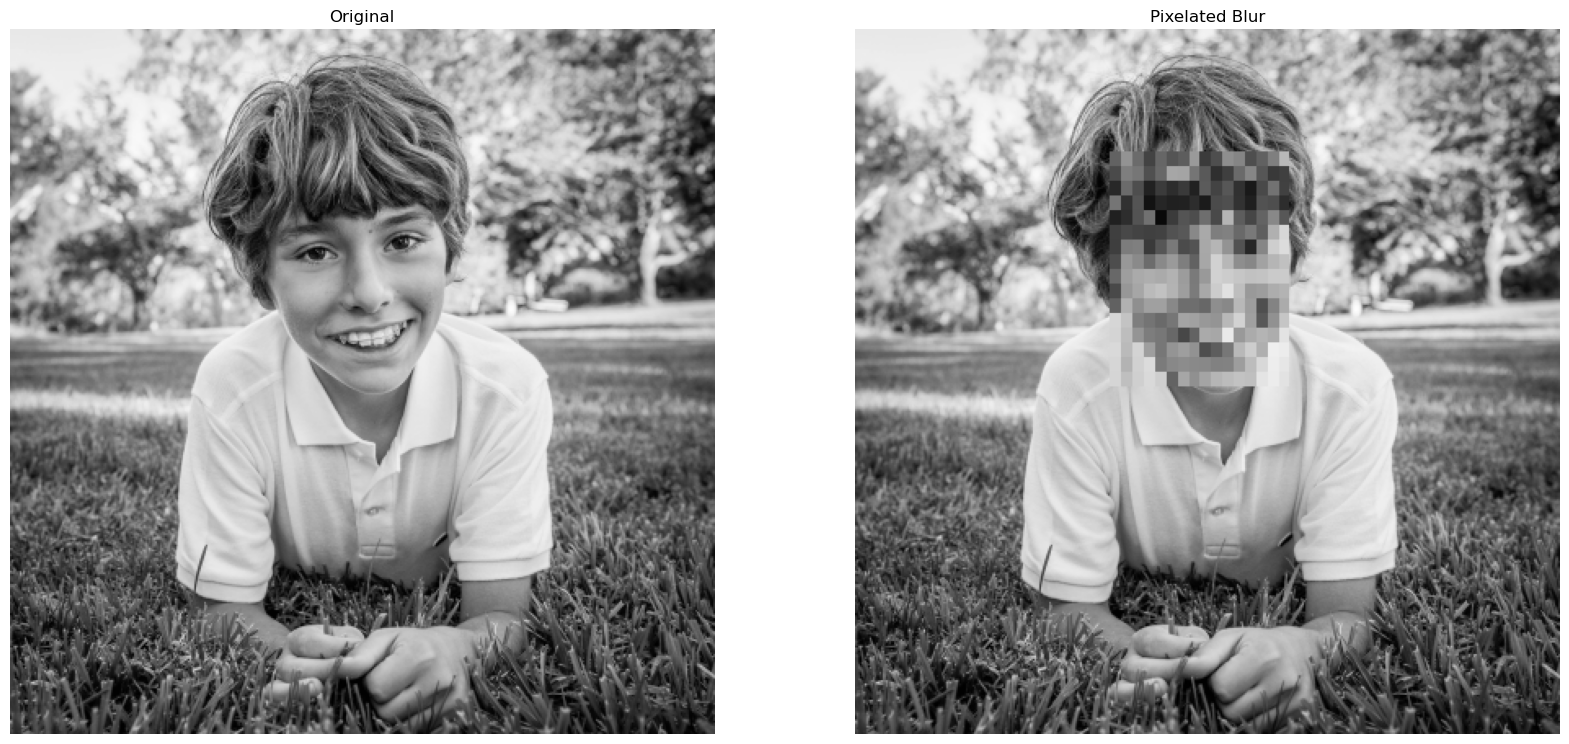

In [29]:
img1_pixel = face_blur_pixelate(img1, net, pixels=16)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);         plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_pixel[:,:,::-1]);   plt.title('Pixelated Blur');